On importe la library comme à constantinople

In [1]:
def generate_batch(x_train, batch_size):
  while True:
    # Sélectionner aléatoirement des indices pour les données d'entraînement
    indices = np.random.randint(low=0, high=x_train.shape[0], size=batch_size)
    # Récupérer les données d'entraînement correspondantes aux indices sélectionnés
    x_batch = x_train[indices]
    # Yielder les données d'entraînement sélectionnées
    yield x_batch


Définition des deux MLP Le premier est le générateur 
Il doit générer des images de taille (28 ,28,1), à partir d'un bruit de taille noise_dim
Le second est le discriminateur, il sort un nombre entre 0 et 1, 1 s'il est sur que l'image est vraie, 0 sinon.
On entraine 'epochs' fois le gan et à chaque étape on entraine d'abord 
k fois le discriminateur et on entraine 1 fois le générateur à maximiser la valeur du discriminateur appliqué à une de ses images, elle sera alors plus "vrai" aux yeux du discriminateur, qui va de nouveau etre entrainé k fois et ainsi de suite. 
Cela permet d'avoir un générateur entrainé et un discriminateur entrainé si les bons paramètres sont utilisés.


Les deux réseaux doivent avoir le meme nombre de couches pour ne pas entrainer de déséquilibre empêchant l'atteinte d'un équilire heuristique entre le générateur et le discriminateur.

In [2]:

import tensorflow as tf
from tensorflow.keras import layers
import matplotlib.pyplot as plt
import numpy as np
from keras.utils.vis_utils import plot_model




In [3]:
tf.config.list_physical_devices('GPU')

[]

In [3]:
noise_dim=100
display_server="http://localhost"
display_port=6087
batch_size=64
num_img_channel=1
img_size=28
sample_interval=64


In [8]:
##Importation des données
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()
# Charger les données MNIST

# Obtenir les indices des images de 2 dans l'ensemble d'entraînement
two_indices = np.where(y_train == 1)[0]
two_indices_test= np.where(y_test == 1)[0]
# Sélectionner les images de 2 dans l'ensemble d'entraînement
x_train_two = x_train[two_indices]

y_train_two = y_train[two_indices]

x_test_two = x_test[two_indices_test]

y_test_two = y_test[two_indices_test]

# Normaliser les données d'entraînement et de test


# Redimensionner les données d'entraînement et de test en forme (batch_size, 28, 28, 1)

x_train = x_train.reshape((-1, 28, 28, 1)).astype('float32')
x_train = (x_train-127.5) / 127.5

x_test = x_test_two.reshape((-1, 28, 28, 1)).astype('float32')
x_test = (x_test_two-127.5) / 127.5
x_train=x_train[:,:,:,]
len(x_train)

60000

In [9]:

#Définition du générateur generator = tf.keras.Sequential()
generator=tf.keras.Sequential()
generator.add(tf.keras.layers.Dense(7*7*128, input_shape=(noise_dim,),use_bias=False,activation="tanh"))

generator.add(tf.keras.layers.BatchNormalization())
generator.add(tf.keras.layers.LeakyReLU(alpha=0.2))
generator.add(tf.keras.layers.Reshape((7,7 ,128 )))


generator.add(tf.keras.layers.Conv2DTranspose(64, kernel_size=(4,4), strides=(2,2), padding='same',use_bias=False))
generator.add(tf.keras.layers.BatchNormalization())
generator.add(tf.keras.layers.LeakyReLU(alpha=0.2))


generator.add(tf.keras.layers.Conv2DTranspose(32, kernel_size=(4,4), strides=(2,2), padding='same',use_bias=False))
generator.add(tf.keras.layers.BatchNormalization())
generator.add(tf.keras.layers.LeakyReLU(alpha=0.2))

generator.add(tf.keras.layers.Conv2DTranspose(1, kernel_size=(4,4), strides=(1,1), padding='same',use_bias=False,activation="tanh"))


In [30]:
generator.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_6 (Dense)             (None, 6272)              627200    
                                                                 
 batch_normalization_18 (Bat  (None, 6272)             25088     
 chNormalization)                                                
                                                                 
 leaky_re_lu_18 (LeakyReLU)  (None, 6272)              0         
                                                                 
 reshape_6 (Reshape)         (None, 7, 7, 128)         0         
                                                                 
 conv2d_transpose_12 (Conv2D  (None, 14, 14, 64)       131072    
 Transpose)                                                      
                                                                 
 batch_normalization_19 (Bat  (None, 14, 14, 64)      

In [10]:

# Créer le discriminateur# Définition du modèle du discriminator
discriminator = tf.keras.Sequential()


discriminator.add(tf.keras.layers.Conv2D(32, (3, 3),strides=(2,2), padding='same', input_shape=(28, 28, 1)))
discriminator.add(tf.keras.layers.BatchNormalization())
discriminator.add(tf.keras.layers.LeakyReLU(alpha=0.2))


discriminator.add(tf.keras.layers.Conv2D(64, (3, 3),strides=(2,2), padding='same'))
discriminator.add(tf.keras.layers.BatchNormalization())
discriminator.add(tf.keras.layers.LeakyReLU(alpha=0.2))


discriminator.add(tf.keras.layers.Flatten())
discriminator.add(tf.keras.layers.Dense(1, activation='sigmoid'))



In [11]:
discriminator.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 14, 14, 32)        320       
                                                                 
 batch_normalization_3 (Batc  (None, 14, 14, 32)       128       
 hNormalization)                                                 
                                                                 
 leaky_re_lu_3 (LeakyReLU)   (None, 14, 14, 32)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 7, 7, 64)          18496     
                                                                 
 batch_normalization_4 (Batc  (None, 7, 7, 64)         256       
 hNormalization)                                                 
                                                                 
 leaky_re_lu_4 (LeakyReLU)   (None, 7, 7, 64)         

In [12]:
plot_model(discriminator)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


Compilations:
Recompiler ne reset pas les poids, 
Cela permet d'actualiser les learning rates pour reprendre l'entrainement
ou de changer la loss function


Fonctions de perte utiles à la génération :

In [13]:
cross_entropy=tf.keras.losses.BinaryCrossentropy(from_logits=True)

def discriminator_loss(real_output,fake_output):
  d_loss_real = cross_entropy(tf.ones_like(real_output),fake_output)
  d_loss_fake = cross_entropy(tf.zeros_like(real_output), fake_output)
  d_loss=d_loss_fake+d_loss_real
  return d_loss


def generate_noise(batch_size, noise_dim):
  return np.random.normal(0, 1, size=(batch_size, noise_dim))

def generator_loss(fake_output):
    return tf.keras.losses.mean_squared_error(tf.ones_like(fake_output),fake_output)





sigma=1
g_optimizer=tf.keras.optimizers.Adam(0.0001,(0.5,0,999))##8178 bons last
d_optimizer=tf.keras.optimizers.Adam(0.0001,(0.5,0.999))## 2242

In [14]:
import glob
from IPython import display


In [17]:
BUFFER_SIZE=60000
batch_size=64
train_dataset=tf.data.Dataset.from_tensor_slices(x_train)
train_dataset=tf.data.Dataset.shuffle(self=train_dataset,buffer_size=BUFFER_SIZE)
train_dataset = train_dataset.batch(batch_size)
len(train_dataset)


938

In [18]:
##Hyperparametres

num_generated_image=25
noise_dim=100

epochs=4

num_discriminator_steps_per_epoch=3
num_generator_steps_per_epoch=1

input_shape=(28,28,1)
seed=tf.random.normal([num_generated_image,noise_dim])

Boucle d'entrainement, on effectue des batch à partir d'une fonction de génération de batchs définie précédemment ,à chaque itération on fait la fonction next qui prend un autre batch n'ayant pas été utilisé.
Pour num_discriminator_steps_per_epoch on entraine le discriminateur avec des fausse images en réponse des 0 et des vrais images avec en réponses des 1



In [19]:
@tf.function
def train_step(images):
    noise = np.random.normal(0,1,[batch_size, noise_dim])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        gen_images=generator(noise,training=True)

        real_output=discriminator(images,training=True)
        fake_output=discriminator(gen_images,training=True)

        g_loss=generator_loss(fake_output=fake_output)
        d_loss=discriminator_loss(real_output,fake_output)

        gradient_of_generator=gen_tape.gradient(g_loss,generator.trainable_variables)
        gradient_of_dicriminator=disc_tape.gradient(d_loss,discriminator.trainable_variables)

    g_optimizer.apply_gradients(zip(gradient_of_generator,generator.trainable_variables))
    d_optimizer.apply_gradients(zip(gradient_of_dicriminator,discriminator.trainable_variables))


In [20]:
@tf.function
def train_step_discriminator(images,noise):

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        
        gen_images=generator(noise,training=True)

        real_output=discriminator(images,training=True)
        fake_output=discriminator(gen_images,training=True)

        d_loss=discriminator_loss(real_output=real_output,fake_output=fake_output)
        

        gradient_of_discriminator=disc_tape.gradient(d_loss,discriminator.trainable_variables)

    d_optimizer.apply_gradients(zip(gradient_of_discriminator,discriminator.trainable_variables))
    noise = np.random.normal(0,sigma,[batch_size, noise_dim])
    gen_images=generator(noise,training=True)
        
    real_output=discriminator(images,training=True)
    fake_output=discriminator(gen_images,training=True)
   
    d_loss=discriminator_loss(real_output=real_output,fake_output=fake_output)
    
    return d_loss

In [21]:
@tf.function
def train_step_generator(noise):
    

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        gen_images=generator(noise,training=True)

        
        fake_output=discriminator(gen_images,training=True)
    
        g_loss=generator_loss(fake_output=fake_output)
        

        gradient_of_generator=gen_tape.gradient(g_loss,generator.trainable_variables)

    g_optimizer.apply_gradients(zip(gradient_of_generator,generator.trainable_variables))
    noise = np.random.normal(0,sigma,[batch_size, noise_dim])
    
    gen_images=generator(noise,training=True)
    fake_output=discriminator(gen_images,training=True)
    g_loss=generator_loss(fake_output=fake_output)
    
   
    return g_loss

In [22]:
x_train.shape

(60000, 28, 28, 1)

In [23]:
def generate_and_save_images(model,epoch,test_input):
    predictions=model(test_input,training=True)
    fig=plt.figure(figsize=(4,4))
    for i in range(predictions.shape[0]):
        plt.subplot(4,4,i+1)
        plt.imshow(predictions[i,:,:,0]*127.5+127.5,cmap='gray')
        plt.axis('off')
        
    plt.show()
    

In [24]:
from tqdm import tqdm
import time 
def train(dataset,epochs,num_discriminator_steps_per_epoch,num_generator_steps_per_epoch):
    
    for epoch in range(epochs):
        start=time.time()
        
        for image_batch in tqdm(dataset):
            
            for n in range(num_discriminator_steps_per_epoch):
                noise = np.random.normal(0,sigma,[batch_size, noise_dim])
                d_loss=train_step_discriminator(image_batch,noise)
                print ("Discriminator step:",n+1)
            
            
            for k in range(num_generator_steps_per_epoch):
                noise = np.random.normal(0,sigma,[batch_size, noise_dim])
                
                print ("Generator step:",k+1)
                g_loss=train_step_generator(noise)
            
            vis.line(
                        X=torch.stack([Tensor(epochs)] * len(loss_legend), dim=1),
                        Y=torch.stack((Tensor(d_losses), Tensor(g_losses)), dim=1),
                        opts={
                            'title': 'loss over time',
                            'legend': loss_legend,
                            'xlabel': 'epoch',
                            'ylabel': 'loss',
                            'width': 512,
                            'height': 512
                    },
                        win=1)
            vis.images(
                        gen_images_seed,
                        nrow=5, win=2,
                        opts={
                            'title': 'GAN output [Epoch {}]'.format(epoch),
                            'width': 512,
                            'height': 512,
                        }
                    )
            


In [25]:
train(dataset=train_dataset,epochs=1,num_discriminator_steps_per_epoch=7,num_generator_steps_per_epoch=1)

  0%|          | 0/938 [00:00<?, ?it/s]c:\Users\Utilisateur\anaconda3\lib\site-packages\keras\backend.py:5676: UserWarning: "`binary_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Sigmoid activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(
  0%|          | 0/938 [00:00<?, ?it/s]


TypeError: in user code:

    File "C:\Users\Utilisateur\AppData\Local\Temp\ipykernel_12892\2419176986.py", line 16, in train_step_discriminator  *
        d_optimizer.apply_gradients(zip(gradient_of_discriminator,discriminator.trainable_variables))
    File "c:\Users\Utilisateur\anaconda3\lib\site-packages\keras\optimizers\optimizer_experimental\optimizer.py", line 1140, in apply_gradients  **
        return super().apply_gradients(grads_and_vars, name=name)
    File "c:\Users\Utilisateur\anaconda3\lib\site-packages\keras\optimizers\optimizer_experimental\optimizer.py", line 634, in apply_gradients
        iteration = self._internal_apply_gradients(grads_and_vars)
    File "c:\Users\Utilisateur\anaconda3\lib\site-packages\keras\optimizers\optimizer_experimental\optimizer.py", line 1166, in _internal_apply_gradients
        return tf.__internal__.distribute.interim.maybe_merge_call(
    File "c:\Users\Utilisateur\anaconda3\lib\site-packages\keras\optimizers\optimizer_experimental\optimizer.py", line 1216, in _distributed_apply_gradients_fn
        distribution.extended.update(
    File "c:\Users\Utilisateur\anaconda3\lib\site-packages\keras\optimizers\optimizer_experimental\optimizer.py", line 1213, in apply_grad_to_update_var  **
        return self._update_step(grad, var)
    File "c:\Users\Utilisateur\anaconda3\lib\site-packages\keras\optimizers\optimizer_experimental\optimizer.py", line 224, in _update_step
        self.update_step(gradient, variable)
    File "c:\Users\Utilisateur\anaconda3\lib\site-packages\keras\optimizers\optimizer_experimental\adam.py", line 194, in update_step
        m.assign_add((gradient - m) * (1 - self.beta_1))

    TypeError: unsupported operand type(s) for -: 'int' and 'tuple'


In [23]:
plt.figure(figsize=(16,16))
gen_test=generator(tf.random.normal([batch_size,noise_dim]))
plt.imshow(gen_test[7],cmap='gray')
plt.show()


: 

: 

1/1 [==============================] - 0s 39ms/step


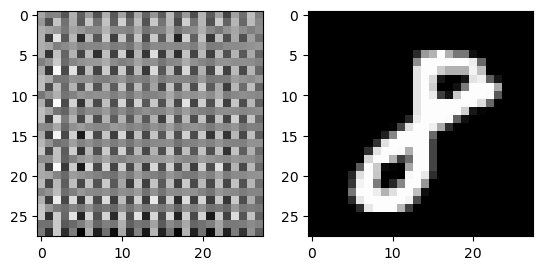

In [757]:

image=generator.predict(seed)[0]

plt.subplot(1, 2, 1)
plt.imshow(image, cmap='gray')

# Afficher l'image de x_batch
plt.subplot(1, 2, 2)
plt.imshow(x_train[0], cmap='gray')
plt.show()

In [447]:
import numpy as np
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()
# Charger les données M
# Obtenir les indices des images de 2 dans l'ensemble d'entraînement
two_indices = np.where(y_test == 2)[0]

# Sélectionner les images de 2 dans l'ensemble d'entraînement
x_train_two = x_train[two_indices]

y_train_two = y_train[two_indices]

x_test_two = x_test[two_indices]

y_test_two = y_test[two_indices]

# Normaliser les données d'entraînement et de test
x_train = x_train_two.astype('float32') / 255
x_test = x_test_two.astype('float32') / 255

# Redimensionner les données d'entraînement et de test en forme (batch_size, 28, 28, 1)
x_train = x_train.reshape((-1, 28, 28, 1))
x_test = x_test.reshape((-1, 28, 28, 1))

In [452]:
noise=np.random.normal(0,4,(batch_size,noise_dim))
gan.fit(noise, real_labels, epochs=6, batch_size=batch_size,steps_per_epoch=2,validation_steps=1)

1/2 [==============>...............] - ETA: 11s - loss: 4.7464e-05WARNING:tensorflow:Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches (in this case, 2 batches). You may need to use the repeat() function when building your dataset.


2/2 [==============================] - 12s 294ms/step - loss: 4.7464e-05


8/8 [==============================] - 1s 143ms/step


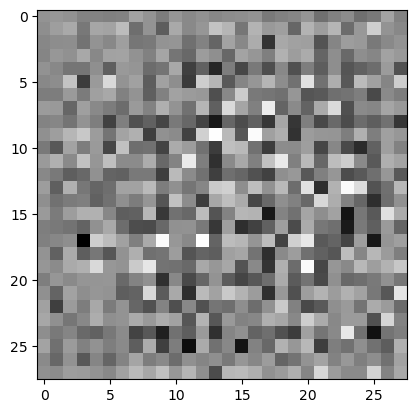

In [42]:
noise=np.random.normal(0,4,(batch_size,noise_dim))
image=generator.predict(noise)[1]

# Créer une figure
plt.figure()

# Afficher l'image
plt.imshow(image, cmap='gray')

# Afficher la figure
plt.show()


In [195]:

num_epochs=40

epochs=100
batch_size=128
num_discriminator_steps_per_epoch=6
num_generator_steps_per_epoch=1
noise_dim=100
input_shape=(28,28,1)
generateur.predict(noise).shape


4/4 [==============================] - 1s 312ms/step


(128, 56, 56, 1)

In [125]:
noise = np.random.normal(0,8, (batch_size, 100))

gan.fit(noise,real_labels,epochs=81,validation_steps=1,steps_per_epoch=3)

Epoch 1/81
3/3 [==============================] - 1s 42ms/step - loss: 15.4249
Epoch 2/81
3/3 [==============================] - 0s 43ms/step - loss: 15.4249
Epoch 3/81
3/3 [==============================] - 0s 42ms/step - loss: 15.4249
Epoch 4/81
3/3 [==============================] - 0s 62ms/step - loss: 15.4249
Epoch 5/81
3/3 [==============================] - 0s 81ms/step - loss: 15.4249
Epoch 6/81
3/3 [==============================] - 0s 46ms/step - loss: 15.4249
Epoch 7/81
3/3 [==============================] - 0s 48ms/step - loss: 15.4249
Epoch 8/81
3/3 [==============================] - 0s 53ms/step - loss: 15.4249
Epoch 9/81
3/3 [==============================] - 0s 49ms/step - loss: 15.4249
Epoch 10/81
3/3 [==============================] - 0s 52ms/step - loss: 15.4249
Epoch 11/81
3/3 [==============================] - 0s 52ms/step - loss: 15.4249
Epoch 12/81
3/3 [==============================] - 0s 49ms/step - loss: 15.4249
Epoch 13/81
1/3 [=========>....................] 

In [275]:
generated_images=[]

indices = np.random.randint(0, x_train.shape[0], size=batch_size)

for epoch in range(epochs):
  train_generator = generate_batch(x_train, batch_size)
  # Entraîner le discriminateur
  for _ in range(num_discriminator_steps_per_epoch):
    # Sélectionner un batch de données réelles
    
    real_labels = np.ones((batch_size, 1))
    fake_labels = np.zeros((batch_size, 1))

    x_batch=next(train_generator)
    
    # Générer un bruit aléatoire
    noise = np.random.normal(0,2,(batch_size, noise_dim))
    
    # Générer des images à partir du bruit
    gen_images = generator.predict(noise)
    generated_images.append(gen_images)
    # Entraîner le discriminateur sur le batch de données réelles et sur les images générées
    d_loss_real = discriminator.train_on_batch(x_batch, real_labels)
    d_loss_fake = discriminator.train_on_batch(gen_images, fake_labels)
    
    # Calculer la loss moyenne du discriminateur
    d_loss = 0.8 * np.add(d_loss_real, d_loss_fake)
  
  # Entraîner le générateur
  for _ in range(num_generator_steps_per_epoch):
    # Générer un bruit aléatoire
    noise = np.random.normal(0,2,(batch_size, noise_dim))
    
    # Entraîner le générateur
    g_loss = gan.train_on_batch(noise, real_labels)


4/4 [==============================] - 1s 320ms/step


InvalidArgumentError: Graph execution error:

Detected at node 'sequential_106/dropout_40/dropout/SelectV2' defined at (most recent call last):
    File "c:\Users\Utilisateur\anaconda3\lib\runpy.py", line 197, in _run_module_as_main
      return _run_code(code, main_globals, None,
    File "c:\Users\Utilisateur\anaconda3\lib\runpy.py", line 87, in _run_code
      exec(code, run_globals)
    File "c:\Users\Utilisateur\anaconda3\lib\site-packages\ipykernel_launcher.py", line 17, in <module>
      app.launch_new_instance()
    File "c:\Users\Utilisateur\anaconda3\lib\site-packages\traitlets\config\application.py", line 846, in launch_instance
      app.start()
    File "c:\Users\Utilisateur\anaconda3\lib\site-packages\ipykernel\kernelapp.py", line 712, in start
      self.io_loop.start()
    File "c:\Users\Utilisateur\anaconda3\lib\site-packages\tornado\platform\asyncio.py", line 199, in start
      self.asyncio_loop.run_forever()
    File "c:\Users\Utilisateur\anaconda3\lib\asyncio\base_events.py", line 601, in run_forever
      self._run_once()
    File "c:\Users\Utilisateur\anaconda3\lib\asyncio\base_events.py", line 1905, in _run_once
      handle._run()
    File "c:\Users\Utilisateur\anaconda3\lib\asyncio\events.py", line 80, in _run
      self._context.run(self._callback, *self._args)
    File "c:\Users\Utilisateur\anaconda3\lib\site-packages\ipykernel\kernelbase.py", line 510, in dispatch_queue
      await self.process_one()
    File "c:\Users\Utilisateur\anaconda3\lib\site-packages\ipykernel\kernelbase.py", line 499, in process_one
      await dispatch(*args)
    File "c:\Users\Utilisateur\anaconda3\lib\site-packages\ipykernel\kernelbase.py", line 406, in dispatch_shell
      await result
    File "c:\Users\Utilisateur\anaconda3\lib\site-packages\ipykernel\kernelbase.py", line 730, in execute_request
      reply_content = await reply_content
    File "c:\Users\Utilisateur\anaconda3\lib\site-packages\ipykernel\ipkernel.py", line 390, in do_execute
      res = shell.run_cell(code, store_history=store_history, silent=silent)
    File "c:\Users\Utilisateur\anaconda3\lib\site-packages\ipykernel\zmqshell.py", line 528, in run_cell
      return super().run_cell(*args, **kwargs)
    File "c:\Users\Utilisateur\anaconda3\lib\site-packages\IPython\core\interactiveshell.py", line 2914, in run_cell
      result = self._run_cell(
    File "c:\Users\Utilisateur\anaconda3\lib\site-packages\IPython\core\interactiveshell.py", line 2960, in _run_cell
      return runner(coro)
    File "c:\Users\Utilisateur\anaconda3\lib\site-packages\IPython\core\async_helpers.py", line 78, in _pseudo_sync_runner
      coro.send(None)
    File "c:\Users\Utilisateur\anaconda3\lib\site-packages\IPython\core\interactiveshell.py", line 3185, in run_cell_async
      has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
    File "c:\Users\Utilisateur\anaconda3\lib\site-packages\IPython\core\interactiveshell.py", line 3377, in run_ast_nodes
      if (await self.run_code(code, result,  async_=asy)):
    File "c:\Users\Utilisateur\anaconda3\lib\site-packages\IPython\core\interactiveshell.py", line 3457, in run_code
      exec(code_obj, self.user_global_ns, self.user_ns)
    File "C:\Users\Utilisateur\AppData\Local\Temp\ipykernel_13812\788602563.py", line 24, in <module>
      d_loss_fake = discriminator.train_on_batch(gen_images, fake_labels)
    File "c:\Users\Utilisateur\anaconda3\lib\site-packages\keras\engine\training.py", line 2478, in train_on_batch
      logs = self.train_function(iterator)
    File "c:\Users\Utilisateur\anaconda3\lib\site-packages\keras\engine\training.py", line 1249, in train_function
      return step_function(self, iterator)
    File "c:\Users\Utilisateur\anaconda3\lib\site-packages\keras\engine\training.py", line 1233, in step_function
      outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "c:\Users\Utilisateur\anaconda3\lib\site-packages\keras\engine\training.py", line 1222, in run_step
      outputs = model.train_step(data)
    File "c:\Users\Utilisateur\anaconda3\lib\site-packages\keras\engine\training.py", line 1023, in train_step
      y_pred = self(x, training=True)
    File "c:\Users\Utilisateur\anaconda3\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "c:\Users\Utilisateur\anaconda3\lib\site-packages\keras\engine\training.py", line 561, in __call__
      return super().__call__(*args, **kwargs)
    File "c:\Users\Utilisateur\anaconda3\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "c:\Users\Utilisateur\anaconda3\lib\site-packages\keras\engine\base_layer.py", line 1132, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "c:\Users\Utilisateur\anaconda3\lib\site-packages\keras\utils\traceback_utils.py", line 96, in error_handler
      return fn(*args, **kwargs)
    File "c:\Users\Utilisateur\anaconda3\lib\site-packages\keras\engine\sequential.py", line 413, in call
      return super().call(inputs, training=training, mask=mask)
    File "c:\Users\Utilisateur\anaconda3\lib\site-packages\keras\engine\functional.py", line 511, in call
      return self._run_internal_graph(inputs, training=training, mask=mask)
    File "c:\Users\Utilisateur\anaconda3\lib\site-packages\keras\engine\functional.py", line 668, in _run_internal_graph
      outputs = node.layer(*args, **kwargs)
    File "c:\Users\Utilisateur\anaconda3\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "c:\Users\Utilisateur\anaconda3\lib\site-packages\keras\engine\base_layer.py", line 1132, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "c:\Users\Utilisateur\anaconda3\lib\site-packages\keras\utils\traceback_utils.py", line 96, in error_handler
      return fn(*args, **kwargs)
    File "c:\Users\Utilisateur\anaconda3\lib\site-packages\keras\layers\regularization\dropout.py", line 120, in call
      output = control_flow_util.smart_cond(
    File "c:\Users\Utilisateur\anaconda3\lib\site-packages\keras\utils\control_flow_util.py", line 108, in smart_cond
      return tf.__internal__.smart_cond.smart_cond(
    File "c:\Users\Utilisateur\anaconda3\lib\site-packages\keras\layers\regularization\dropout.py", line 116, in dropped_inputs
      return self._random_generator.dropout(
    File "c:\Users\Utilisateur\anaconda3\lib\site-packages\keras\backend.py", line 2162, in dropout
      return tf.nn.dropout(
Node: 'sequential_106/dropout_40/dropout/SelectV2'
condition [128,7,7,32], then [128,14,14,32], and else [] must be broadcastable
	 [[{{node sequential_106/dropout_40/dropout/SelectV2}}]] [Op:__inference_train_function_2618805]

In [755]:
plt.figure(figsize=(10, 10))
for i, image in enumerate(generated_images):
  plt.subplot(10, 10, i+1)
  plt.imshow(image, cmap='gray')
  plt.axis('off')
plt.show()


NameError: name 'generated_images' is not defined

<Figure size 1000x1000 with 0 Axes>